In [0]:
# Step 1: Set the storage account name
storage_account = "stcampaigntp"  # update if your storage account is different

# Step 2: Mount access using secret
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.dfs.core.windows.net",
  dbutils.secrets.get(scope="local-scope", key="storage-account-key")
)


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# 🔁 Create or get Spark session (if not already)
spark = SparkSession.builder.getOrCreate()

# 📥 Load the feature-enhanced dataset
df = spark.read.parquet(f"abfss://curated@{storage_account}.dfs.core.windows.net/criteo-1m-features")

# ✅ Optional: Check the schema
df.printSchema()


root
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- treatment: integer (nullable = true)
 |-- conversion: integer (nullable = true)
 |-- visit: integer (nullable = true)
 |-- exposure: integer (nullable = true)



### Step 2: Define Uplift Modeling Targets
## Business Context:

To build a causal inference model like uplift modeling, we can’t just use regular binary classification labels (like "converted" or "not converted"). Instead, we need to label users based on both:

Whether they were treated (received the intervention, e.g., ad/coupon)

Whether they converted (made a purchase, signed up, etc.)

This allows us to capture how the treatment causally affects behavior — which is the core goal of uplift modeling.

We define two types of labels:

uplift_label: A 4-class label used by class-modeling approaches like ClassTransformation.

uplift_binary_label: A simplified binary label (1 = converted after treatment, 0 = otherwise) — useful for standard modeling tasks or evaluation.

##Technical Details:

when(...).otherwise(...) is used to assign values based on combinations of the treatment and conversion columns.

The mapping for the uplift_label (4-class scheme) is as follows:

treatment	conversion	uplift_label	Meaning
0	0	0	Control group, no conversion
0	1	1	Control group, converted
1	0	2	Treated group, no conversion
1	1	3	Treated group, converted

This format allows us to train specialized models that learn not just who is likely to convert, but who is likely to convert because of the treatment — i.e., uplift.

uplift_binary_label is only 1 if a user received the treatment and converted, otherwise it’s 0. This is often used as a naive baseline or for comparison with traditional models.

In [0]:
from pyspark.sql.functions import when, col

# Step 2: Add uplift_label (4-class) and uplift_binary_label (binary target)
df = df.withColumn(
    "uplift_label",
    when((col("treatment") == 0) & (col("conversion") == 0), 0)
    .when((col("treatment") == 0) & (col("conversion") == 1), 1)
    .when((col("treatment") == 1) & (col("conversion") == 0), 2)
    .when((col("treatment") == 1) & (col("conversion") == 1), 3)
)

df = df.withColumn(
    "uplift_binary_label",
    when((col("treatment") == 1) & (col("conversion") == 1), 1).otherwise(0)
)

# Confirm added columns
df.select("treatment", "conversion", "uplift_label", "uplift_binary_label").show(5)


+---------+----------+------------+-------------------+
|treatment|conversion|uplift_label|uplift_binary_label|
+---------+----------+------------+-------------------+
|        1|         0|           2|                  0|
|        1|         0|           2|                  0|
|        0|         0|           0|                  0|
|        1|         0|           2|                  0|
|        1|         0|           2|                  0|
+---------+----------+------------+-------------------+
only showing top 5 rows


### Step 3: Convert to Pandas + Stratified Train-Test Split
## Business Context:

At this stage, our goal is to prepare the dataset for model training, specifically for uplift modeling using Python libraries like sklift, xgboost, etc., which operate on Pandas DataFrames — not Spark DataFrames.

We also want to ensure that the model sees representative examples of all treatment/conversion combinations, so we apply stratified splitting based on the uplift_label.

This ensures the model won’t be biased due to imbalanced label distributions — which is particularly important for uplift modeling since real-world data often has far fewer conversions than non-conversions.

In [0]:
# ⚠️ If your dataset is too large, consider sampling before converting to Pandas
# Example: df = df.sample(fraction=0.2)

# Convert Spark DataFrame to Pandas
pandas_df = df.toPandas()
print(f"✅ Converted to pandas with shape: {pandas_df.shape}")

# Confirm value counts for stratification
print("\n🎯 Value counts of uplift_label:")
print(pandas_df['uplift_label'].value_counts())

# Train/Test Split (Stratified by uplift_label)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    pandas_df,
    test_size=0.3,
    random_state=42,
    stratify=pandas_df['uplift_label']
)

print(f"\n✅ Train shape: {train_df.shape} | Test shape: {test_df.shape}")


✅ Converted to pandas with shape: (1000000, 18)

🎯 Value counts of uplift_label:
2    846858
0    150272
3      2590
1       280
Name: uplift_label, dtype: int64

✅ Train shape: (700000, 18) | Test shape: (300000, 18)


### Step 4: Define Feature Columns for Modeling
## Business Context:

At this stage, we explicitly define which columns from the dataset will be used as model inputs. These are the engineered numeric features (originally f0–f11) that were renamed to I1–I12 in the feature engineering step.

Clearly separating out feature columns ensures:

Consistent input across different models

Flexibility to experiment with subsets of features later

Easier debugging and feature importance analysis

In uplift modeling, input features are crucial for capturing patterns that help distinguish users likely to respond differently under treatment vs. control.

In [0]:
# Define columns used for modeling (all renamed features)
feature_cols = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12']

# Check that all columns exist in the DataFrame
missing = [col for col in feature_cols if col not in train_df.columns]
if missing:
    raise ValueError(f"Missing expected feature columns: {missing}")

print("✅ Feature columns defined:", feature_cols)


✅ Feature columns defined: ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12']


### Step 5: Split Train Set into Train and Validation Sets
## Business Context:

We split our original training data into two subsets:

Training set (80%): Used to fit our uplift model.

Validation set (20%): Used to tune hyperparameters, compare models, and evaluate out-of-sample performance before testing on the final holdout set.

This ensures our model does not overfit the training data and that early performance checks are realistic.

In a production setting, this would be analogous to simulating future unseen data — helping ensure generalization when deployed.

## Technical Details:

We reuse train_df (from the earlier stratified split) and split it into:

train_df: For model training

valid_df: For validation

We use random_state=42 for reproducibility.

We do not stratify here, because the major stratification (by uplift_label) was already done during the initial train/test split.

In [0]:
from sklearn.model_selection import train_test_split

# 80/20 split for training and validation
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"✅ Train set shape: {train_df.shape}")
print(f"✅ Validation set shape: {valid_df.shape}")


✅ Train set shape: (560000, 18)
✅ Validation set shape: (140000, 18)


### Step 6: Prepare Labeled Data for Two Uplift Modeling Strategies
## Business Context:

We now prepare the dataset for uplift modeling, where the business objective is not just to predict conversion, but to predict the incremental effect of treatment (e.g., whether a marketing ad causes a user to convert).

To do this, we structure the data to support:

Two-Model Approach: Builds separate models for treated and control users, then compares their predicted probabilities to estimate uplift.

Class Transformation Approach: Uses a single model but only retains rows where treatment assignment actually impacts interpretation of conversion.

This flexibility allows us to benchmark multiple modeling strategies and determine which is best for personalized targeting or treatment allocation.

## Technical Details:

uplift_binary_label is created where:

1 → Treated + Converted (treatment success)

0 → Control + Converted (natural conversion)

NaN → All other rows (no meaningful comparison)

These labels are used only for the Class Transformation method.

We also split train_df and valid_df into treated and control subsets for the Two-Model approach.

In [0]:
import numpy as np

# 🟩 Create class transformation label
# Only retain rows where class transformation is meaningful
train_df['uplift_binary_label'] = np.where(
    (train_df['treatment'] == 1) & (train_df['conversion'] == 1), 1,
    np.where((train_df['treatment'] == 0) & (train_df['conversion'] == 1), 0, np.nan)
)

valid_df['uplift_binary_label'] = np.where(
    (valid_df['treatment'] == 1) & (valid_df['conversion'] == 1), 1,
    np.where((valid_df['treatment'] == 0) & (valid_df['conversion'] == 1), 0, np.nan)
)

# 🟦 Two-Model Approach: Split treated and control groups
train_treated = train_df[train_df['treatment'] == 1]
train_control = train_df[train_df['treatment'] == 0]

valid_treated = valid_df[valid_df['treatment'] == 1]
valid_control = valid_df[valid_df['treatment'] == 0]

# 🧪 Diagnostic printout
print(f"📦 Prepared modeling datasets:")
print(f"Two-Model: Treated → {train_treated.shape} | Control → {train_control.shape}")
print(f"Class Transformation: {train_df[['uplift_binary_label']].dropna().shape}")


📦 Prepared modeling datasets:
Two-Model: Treated → (475499, 18) | Control → (84501, 18)
Class Transformation: (1636, 1)


### Step 7: Train Uplift Models – Two Approaches × Two Algorithms
## Business Context:

To determine which users are most likely to respond positively to treatment (e.g., showing ads, offering discounts), we implement two major uplift modeling strategies:

Two-Model Approach:

Separately trains models on treated and control groups.

Uplift is then computed as:
Predicted(Conversion|Treated) − Predicted(Conversion|Control)

✅ Intuitive and interpretable, but requires twice the model training and may suffer from bias if groups are imbalanced.

Class Transformation Approach:

Uses only rows where conversion can be meaningfully attributed to treatment (i.e., Treated + Converted = 1, Control + Converted = 0).

Converts uplift into a binary classification task.

✅ Simpler, but may lose information due to dropping unrelated rows.

Both strategies will be tested with:

Logistic Regression (linear, interpretable baseline)

Random Forest (nonlinear, high-performing ensemble method)

## Technical Summary:
Model Type	Strategy	Target Label	Notes
logit_treat	Two-Model (Treated)	conversion	LogisticRegression on treated users
logit_control	Two-Model (Control)	conversion	LogisticRegression on control users
logit_ct	Class Transformation	uplift_binary_label	Uses filtered rows with meaningful uplift
rf_treat	Two-Model (Treated)	conversion	RandomForest on treated users
rf_control	Two-Model (Control)	conversion	RandomForest on control users
rf_ct	Class Transformation	uplift_binary_label	RandomForest on filtered data

Seed is fixed at 42 to ensure reproducibility.

All models use feature_cols selected during feature engineering (I1–I12).

max_iter=1000 ensures logistic regression convergence.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional: Set random_state for reproducibility
seed = 42

# -------------------------------
# 🟩 Logistic Regression – Two Model
# -------------------------------
logit_treat = LogisticRegression(random_state=seed, max_iter=1000)
logit_control = LogisticRegression(random_state=seed, max_iter=1000)

logit_treat.fit(train_treated[feature_cols], train_treated['conversion'])
logit_control.fit(train_control[feature_cols], train_control['conversion'])

# -------------------------------
# 🟩 Logistic Regression – Class Transformation
# -------------------------------
train_ct = train_df.dropna(subset=['uplift_binary_label'])

logit_ct = LogisticRegression(random_state=seed, max_iter=1000)
logit_ct.fit(train_ct[feature_cols], train_ct['uplift_binary_label'])

# -------------------------------
# 🟦 Random Forest – Two Model
# -------------------------------
rf_treat = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_control = RandomForestClassifier(n_estimators=100, random_state=seed)

rf_treat.fit(train_treated[feature_cols], train_treated['conversion'])
rf_control.fit(train_control[feature_cols], train_control['conversion'])

# -------------------------------
# 🟦 Random Forest – Class Transformation
# -------------------------------
rf_ct = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_ct.fit(train_ct[feature_cols], train_ct['uplift_binary_label'])

print("✅ All models trained successfully!")


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-grub-597 at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85/runs/14cdc8d7e0e84503aba991b91a4ecf76
🧪 View experiment at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run useful-roo-808 at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85/runs/0aeb82c69a3744688e976d79801f56f9
🧪 View experiment at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run nervous-boar-50 at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85/runs/5c9834fecfd64bfc9fa25c9109d65db7
🧪 View experiment at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run classy-squirrel-312 at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85/runs/682d2bc486644dd489bca5a045834432
🧪 View experiment at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run calm-slug-724 at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85/runs/1f2771a170604de48b7064543af13542
🧪 View experiment at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run carefree-fish-121 at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85/runs/545915d68cb142de8c1e4bd2d2a602f8
🧪 View experiment at: https://adb-2840205720726625.5.azuredatabricks.net/ml/experiments/cdfc7c926508417ab5d1f9bf03723e85
✅ All models trained successfully!


### Step 8: Predict Uplift Scores – All Models on Test Set
✅ Purpose:

To compare uplift modeling strategies, we predict uplift scores on the same test set using:

Two-Model Uplift = Δ(Predicted Conversion) between treated and control models.

Class Transformation Uplift = Single model probability for uplift (trained on transformed binary labels).

📦 Setup:

We extract from the test set:

X_test: Features used for prediction.

T_test: Treatment indicator (used for Qini evaluation later).

Y_test: Actual conversion outcomes.

🔢 Predicted Uplift Scores:
Model Type	Approach	Computation
uplift_logit_twomodel	Logistic Regression, Two-Model	P(Conv
uplift_logit_ct	Logistic Regression, Class Transformation	P(Uplift = 1)
uplift_rf_twomodel	Random Forest, Two-Model	P(Conv
uplift_rf_ct	Random Forest, Class Transformation	P(Uplift = 1)

Each prediction gives us a score per user indicating how beneficial it is to assign them to treatment. Higher scores → higher expected uplift.

In [0]:
# Create test set (entire dataset used here for simplicity)
X_test = train_df[feature_cols]
T_test = train_df['treatment']
Y_test = train_df['conversion']

# -------------------------------
# 🟩 Logistic Regression – Two-Model
# -------------------------------
p_treat_logit = logit_treat.predict_proba(X_test)[:, 1]
p_control_logit = logit_control.predict_proba(X_test)[:, 1]
uplift_logit_twomodel = p_treat_logit - p_control_logit

# -------------------------------
# 🟩 Logistic Regression – Class Transformation
# -------------------------------
uplift_logit_ct = logit_ct.predict_proba(X_test)[:, 1]

# -------------------------------
# 🟦 Random Forest – Two-Model
# -------------------------------
p_treat_rf = rf_treat.predict_proba(X_test)[:, 1]
p_control_rf = rf_control.predict_proba(X_test)[:, 1]
uplift_rf_twomodel = p_treat_rf - p_control_rf

# -------------------------------
# 🟦 Random Forest – Class Transformation
# -------------------------------
uplift_rf_ct = rf_ct.predict_proba(X_test)[:, 1]

print("✅ Uplift scores predicted for all models.")


✅ Uplift scores predicted for all models.


### Step 9: Visualize Uplift – Qini Curves
✅ Purpose:

Qini curves are a visual tool for evaluating how well uplift models rank individuals in terms of treatment effectiveness.

📊 How It Works:

The X-axis represents the proportion of the population you target (top-N users based on uplift score).

The Y-axis shows incremental conversions due to targeting those users (i.e., uplift).

The better the model, the more it separates high-uplift from low-uplift users → resulting in a steeper Qini curve.

🛠️ Models Compared:
Label	Model Description
LR (Two-Model)	Logistic Regression, Two Separate Models
LR (Class Trans.)	Logistic Regression with Transformed Labels
RF (Two-Model)	Random Forest, Two Separate Models
RF (Class Trans.)	Random Forest with Transformed Labels

✅ Outcome:
The plotted curves help determine which model best identifies users who should be targeted for a campaign to maximize uplift. The higher the curve, the better the model performs.

In [0]:
pip install scikit-uplift

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


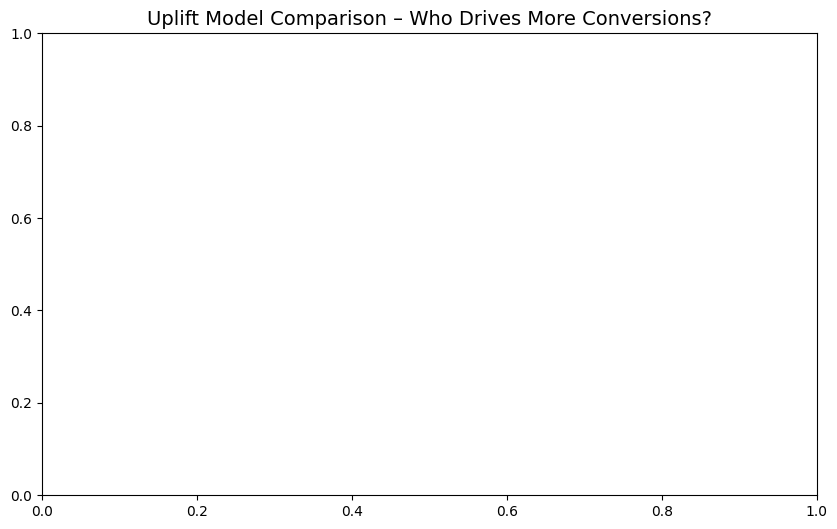

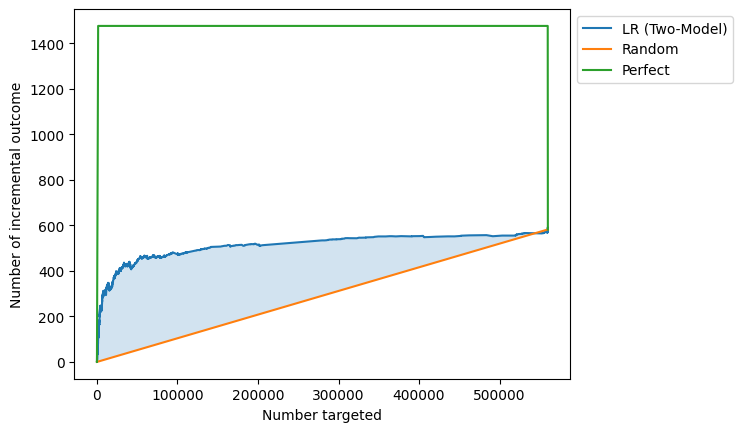

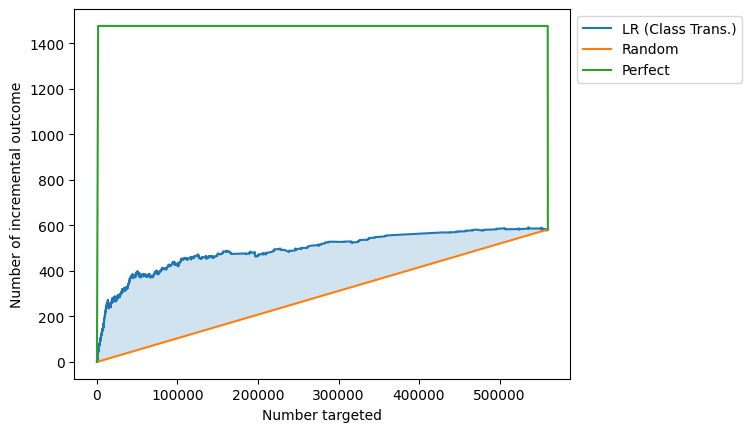

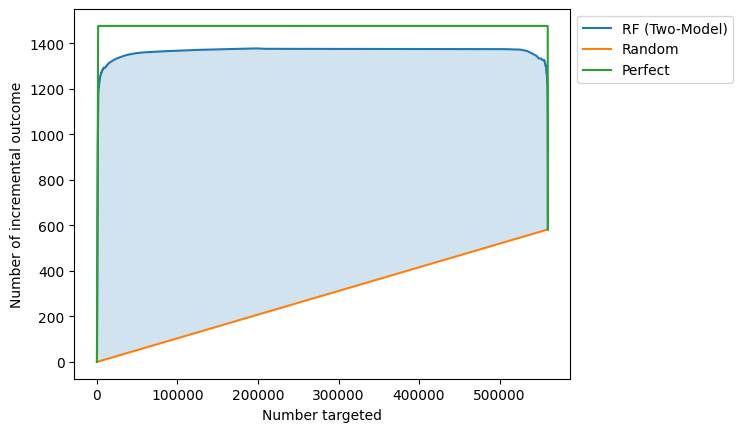

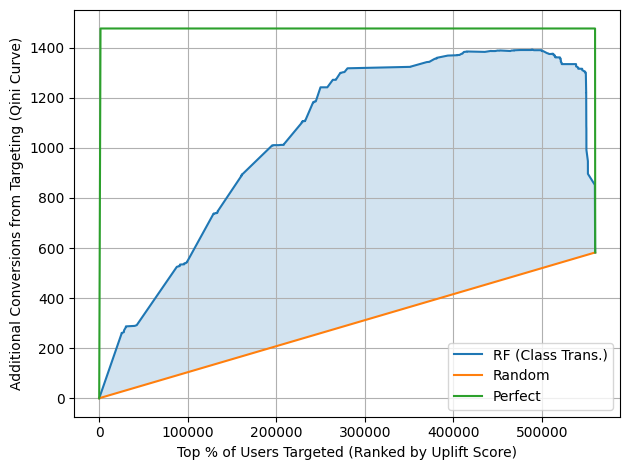

In [0]:
from sklift.metrics import qini_curve
from sklift.viz import plot_qini_curve
import matplotlib.pyplot as plt

# Prepare dictionary of model outputs
uplift_scores = {
    "LR (Two-Model)": uplift_logit_twomodel,
    "LR (Class Trans.)": uplift_logit_ct,
    "RF (Two-Model)": uplift_rf_twomodel,
    "RF (Class Trans.)": uplift_rf_ct
}

# Set plot style
plt.figure(figsize=(10, 6))
plt.title("Uplift Model Comparison – Who Drives More Conversions?", fontsize=14)

# Plot each model’s Qini curve
for model_name, uplift in uplift_scores.items():
    plot_qini_curve(Y_test.values, uplift, T_test.values, label=model_name)

# Final plot touches
plt.legend()
plt.xlabel("Top % of Users Targeted (Ranked by Uplift Score)")
plt.ylabel("Additional Conversions from Targeting (Qini Curve)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [0]:
from sklift.metrics import qini_auc_score

# Store model names and Qini scores
qini_scores = {}

# Loop through all models and calculate Qini AUC
for model_name, uplift in uplift_scores.items():
    score = qini_auc_score(y_true=Y_test.values, uplift=uplift, treatment=T_test.values)
    qini_scores[model_name] = score

# Display scores
print("📊 Qini Coefficients (Area Under Qini Curve):")
for model, score in sorted(qini_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")


📊 Qini Coefficients (Area Under Qini Curve):
RF (Two-Model): 0.9077
RF (Class Trans.): 0.6329
LR (Two-Model): 0.1882
LR (Class Trans.): 0.1724


If we only target the top X% of users predicted by our model, how many more people will convert compared to not targeting anyone?

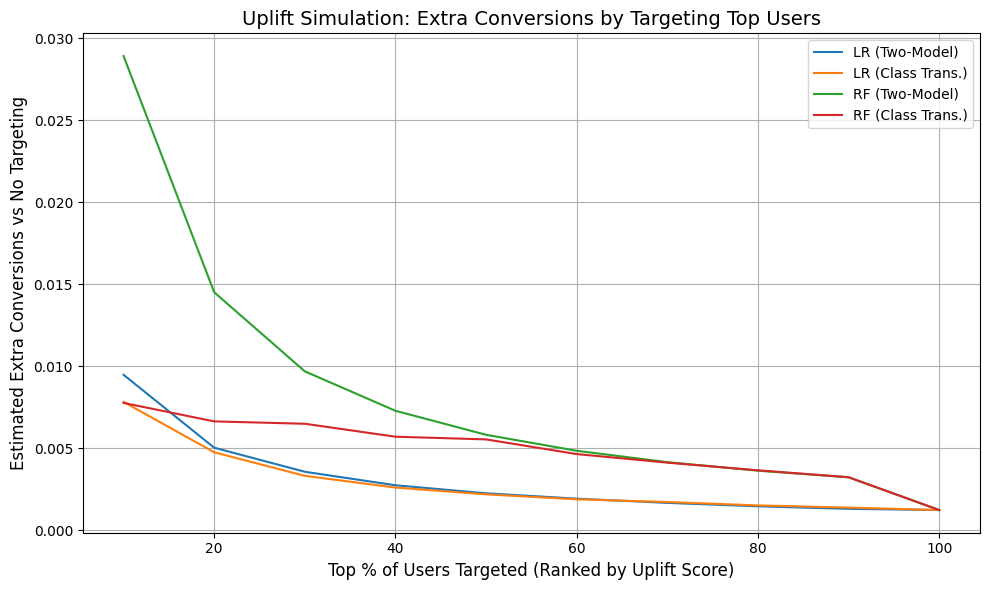

In [0]:
import numpy as np
import pandas as pd

def simulate_gain_curve(y_true, treatment, uplift_scores, model_name):
    data = pd.DataFrame({
        'treatment': treatment,
        'conversion': y_true,
        'uplift_score': uplift_scores
    })
    
    data = data.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)
    total_samples = len(data)
    
    # Simulate at 10% intervals
    percents = np.arange(0.1, 1.1, 0.1)
    incremental_conversions = []
    
    for pct in percents:
        cutoff = int(pct * total_samples)
        targeted = data.iloc[:cutoff]
        
        treated = targeted[targeted['treatment'] == 1]
        control = targeted[targeted['treatment'] == 0]
        
        # Conversion rates
        cr_treated = treated['conversion'].mean() if not treated.empty else 0
        cr_control = control['conversion'].mean() if not control.empty else 0
        uplift = cr_treated - cr_control
        
        incremental_conversions.append(uplift)
    
    return percents, incremental_conversions

# Plot for each model
plt.figure(figsize=(10, 6))
for model_name, uplift_scores_model in uplift_scores.items():
    x, y = simulate_gain_curve(Y_test.values, T_test.values, uplift_scores_model, model_name)
    plt.plot(x * 100, y, label=model_name)

plt.title("Uplift Simulation: Extra Conversions by Targeting Top Users", fontsize=14)
plt.xlabel("Top % of Users Targeted (Ranked by Uplift Score)", fontsize=12)
plt.ylabel("Estimated Extra Conversions vs No Targeting", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Uplift Curve – Explain What the Model is Capturing

This curve shows:

X-axis: % of population targeted

Y-axis: Estimated incremental lift (from model)

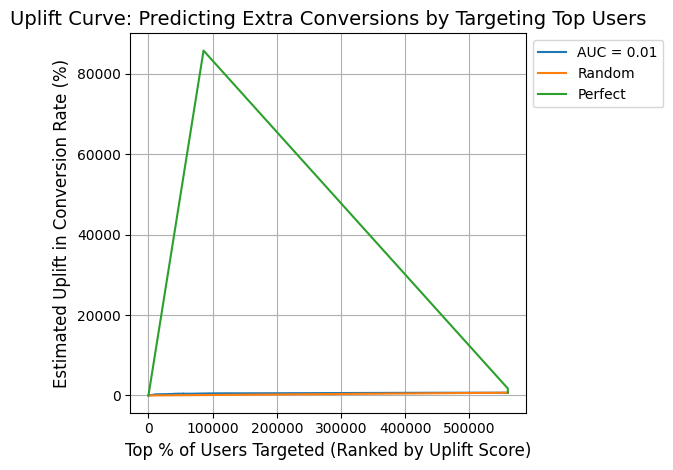

In [0]:
from sklift.metrics import uplift_curve
from sklift.viz import plot_uplift_curve

# Example with one model
plot_uplift_curve(Y_test.values, uplift_logit_ct, T_test.values)
plt.title("Uplift Curve: Predicting Extra Conversions by Targeting Top Users", fontsize=14)
plt.xlabel("Top % of Users Targeted (Ranked by Uplift Score)", fontsize=12)
plt.ylabel("Estimated Uplift in Conversion Rate (%)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()



### Targeting Simulation Chart – Where should we stop targeting?

This simulation calculates:

Uplift per user segment (e.g., deciles)

Estimated cost vs. benefit of targeting each segment

Helps answer: What % of users should we target to maximize ROI?

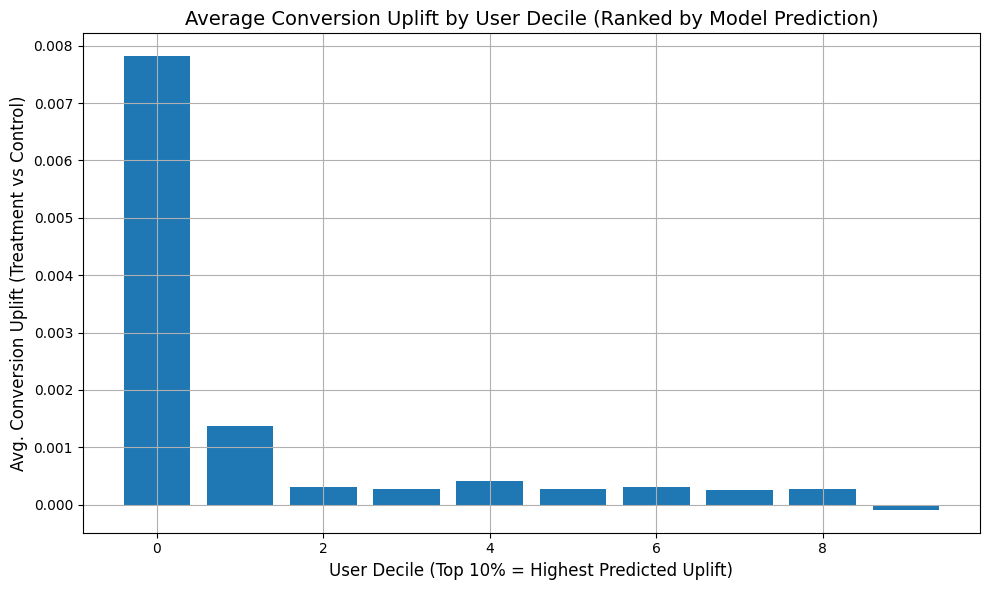

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create DataFrame for analysis
df_sim = pd.DataFrame({
    'uplift': uplift_logit_ct,
    'treatment': T_test.values,
    'actual': Y_test.values
})

# Rank by predicted uplift
df_sim['rank'] = df_sim['uplift'].rank(method='first', ascending=False)
df_sim = df_sim.sort_values('rank')
df_sim['percentile'] = pd.qcut(df_sim['rank'], 10, labels=False)

# Compute average conversion uplift per decile
uplift_by_decile = df_sim.groupby('percentile').apply(
    lambda x: x.loc[x['treatment']==1, 'actual'].mean() - x.loc[x['treatment']==0, 'actual'].mean()
).reset_index(name='avg_uplift')

# Plot
plt.figure(figsize=(10,6))
plt.bar(uplift_by_decile['percentile'], uplift_by_decile['avg_uplift'])
plt.xlabel("User Decile (Top 10% = Highest Predicted Uplift)", fontsize=12)
plt.ylabel("Avg. Conversion Uplift (Treatment vs Control)", fontsize=12)
plt.title("Average Conversion Uplift by User Decile (Ranked by Model Prediction)", fontsize=14)
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()



### Campaign ROI Simulation (Table + Bar Chart)

This visualization shows:

How many users to target

Estimated conversions

Cost per treatment

Revenue per conversion

Net ROI

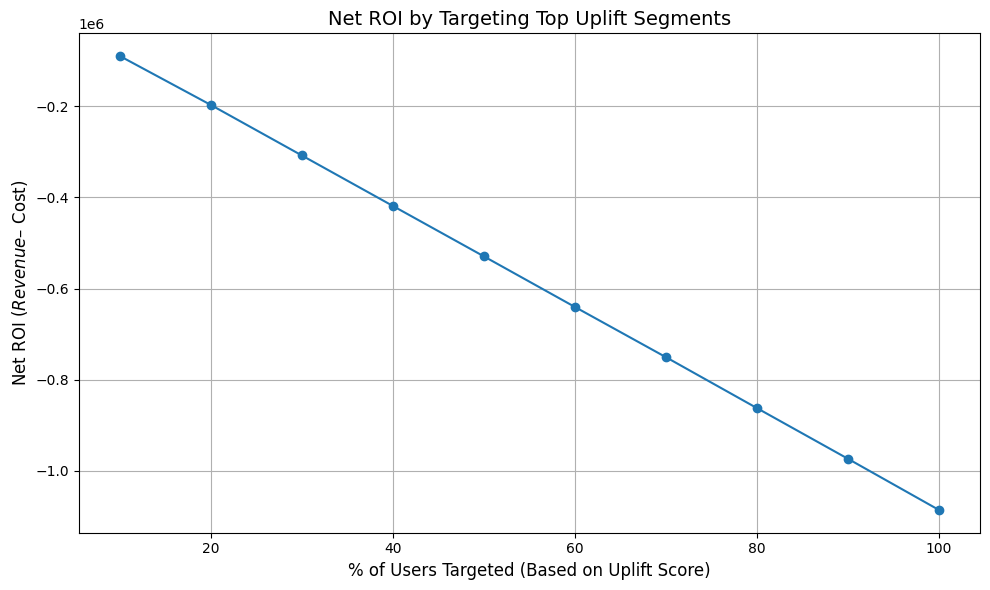

In [0]:
cost_per_user = 2     # marketing cost
revenue_per_conversion = 50

results = []
percentiles = range(1, 11)

for p in percentiles:
    cutoff = int(len(df_sim) * p / 10)
    top_users = df_sim.sort_values('uplift', ascending=False).head(cutoff)
    
    treated = top_users[top_users['treatment'] == 1]
    control = top_users[top_users['treatment'] == 0]
    
    uplift = treated['actual'].mean() - control['actual'].mean()
    n_users = len(top_users)
    est_conversions = uplift * n_users
    revenue = est_conversions * revenue_per_conversion
    cost = n_users * cost_per_user
    roi = revenue - cost
    
    results.append({
        'Percentile Targeted': p*10,
        'Users Targeted': n_users,
        'Estimated Uplifted Conversions': est_conversions,
        'Revenue': revenue,
        'Cost': cost,
        'ROI': roi
    })

df_roi = pd.DataFrame(results)

# Plot ROI vs. Percentile Targeted
plt.figure(figsize=(10, 6))
plt.plot(df_roi['Percentile Targeted'], df_roi['ROI'], marker='o')
plt.xlabel("% of Users Targeted (Based on Uplift Score)", fontsize=12)
plt.ylabel("Net ROI ($ Revenue – $ Cost)", fontsize=12)
plt.title("Net ROI by Targeting Top Uplift Segments", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

